In [1]:
import numpy as np
import pandas as pd
import random
import scipy.stats as st #数值运算
import matplotlib.pyplot as plt
import seaborn as sns #画图
import networkx as nx
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#FilmTrust 数据集 35497个rating数据, 1632个trust数据
column_names_1 = ['user_id', 'item_id', 'rating']
rating = pd.read_csv(r"C:\Users\user\Desktop\Bachelor Project\dataset\filmtrust\raw\ratings.txt",sep=' ',names=column_names_1)

column_names_2 = ['trustor','trustee','trust_value']
trust = pd.read_csv(r"C:\Users\user\Desktop\Bachelor Project\dataset\filmtrust\raw\trust.txt",sep=' ',names=column_names_2)

In [3]:
n_users = rating['user_id'].nunique()#用户的数量
n_items = rating['item_id'].nunique() #电影的数量
print("用户的数量:",n_users)
print("电影的数量:",n_items)

用户的数量: 1508
电影的数量: 2071


In [4]:
user_rating = pd.DataFrame(rating.groupby('user_id')['rating'].mean()) #计算出每个人的平均打分
user_rating.head()

,rating
user_id,
0,3.416667
1,2.000000
2,2.829016
3,2.333333
4,3.000000


In [5]:
item_rating = pd.DataFrame(rating.groupby('item_id')['rating'].mean()) #每个物品的平均得分
item_rating['num_of_ratings'] = pd.DataFrame(rating.groupby('item_id')['rating'].count()) #每个物品得到的评分数
item_rating.reset_index(inplace=True)
item_rating.head()

,item_id,rating,num_of_ratings
0,0,2.985566,866
1,1,3.192896,915
2,2,3.036602,724
3,3,3.185129,659
4,4,3.217454,699


In [6]:
###协同过滤算法的测试,并计算误差
df1 = pd.read_csv("D:/dataset/filmtrust/ratings.txt",sep='\s+',names=column_names_1)
df1['item_id'] = df1['item_id'] - 1 #user_id和item_id本来从1开始，-1让下标从0开始
df1['user_id'] = df1['user_id'] - 1

train_data, test_data = train_test_split(df1,test_size=0.25,random_state=101)
#为训练集和测试集创建两个用户-物品矩阵
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]
    
#计算用户相似度和物品相似度
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1 - pairwise_distances(train_data_matrix, metric='cosine') 
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')

#计算X(m,k)
def predict(ratings, similarity, which_type):
    if which_type == 'user':
        mean_user_rating = ratings.mean(axis=1)#平均用户评分
        ratings_diff = ratings - mean_user_rating[:,np.newaxis]
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif which_type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

#所有用户对所有物品的可能评分的矩阵
item_prediction = predict(train_data_matrix, item_similarity, which_type='item') #基于物品
user_prediction = predict(train_data_matrix, user_similarity, which_type='user') #基于用户

#计算均方根误差
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

print('User-based CF RMSE/基于用户的协同过滤均方根误差: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE/基于物品的协同过滤均方根误差: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE/基于用户的协同过滤均方根误差: 2.211622477767171
Item-based CF RMSE/基于物品的协同过滤均方根误差: 2.599439474939228


In [7]:
connected_users = list(trust['trustor'].unique())
total = n_users
users = []
for i in range(1,total+1):
    users.append(i)
#print(len(users))
    
non_connected_users = []
for i in users:
    if i not in connected_users:
        non_connected_users.append(i)
print("有连接的用户数：",len(connected_users))
print("孤立的用户数：",len(non_connected_users))

有连接的用户数： 522
孤立的用户数： 986


In [8]:
#为trust数据集建立邻接表，输入：trust数据，邻接表地址,是否包含孤立节点
def build_adjfile(trust_matrix,file_directory,n_profiles,include_orphaned_nodes):
    adjlist = []
    current = -1
    index = -1
    for line in trust_matrix.itertuples():
        if line[1] != current:
            index += 1
            current = line[1]
            adjlist.append([])
            adjlist[index].append(line[1])
            adjlist[index].append(line[2])
        else:
            adjlist[index].append(line[2])
 
    if include_orphaned_nodes == True:
        connected_users = list(trust_matrix['trustor'].unique())
        total = n_users+n_profiles
        users = []
        for i in range(1,total+1):
            users.append(i)
        #print(len(users))
            
        non_connected_users = []
        for i in users:
            if i not in connected_users:
                non_connected_users.append(i)
        #print(len(connected_users))
        #print(len(non_connected_users))
        for i in non_connected_users:
            temp = []
            temp.append(i)
            adjlist.append(temp)
        create_file(file_directory,adjlist)
    else:
        create_file(file_directory,adjlist)    

def create_file(file_directory,adjlist):
    output = open(file_directory,'w',encoding='gbk')
    for row in adjlist:
        for num in row:
            output.write(str(num))
            output.write(' ')
        output.write('\n')
    output.close()

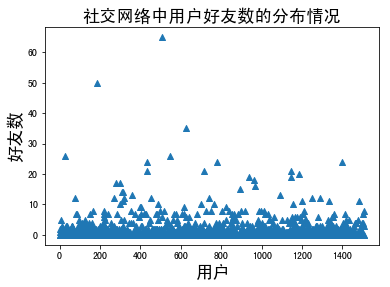

In [9]:
file_directory = r"C:\Users\user\Desktop\Bachelor Project\dataset\filmtrust\adjfiles\adjfile_orphan.txt"
build_adjfile(trust,file_directory,0,True)
G1=nx.read_adjlist(file_directory,nodetype=int)
degree = dict(nx.degree(G1))
plt.scatter(degree.keys(),degree.values(), marker='^')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("用户",fontsize='xx-large')
plt.ylabel("好友数",fontsize='xx-large')
plt.title("社交网络中用户好友数的分布情况",fontsize='xx-large')
plt.show()

In [10]:
#计算不包含孤立节点时社交网络每个结点度的均值和标准差
file_directory = r"C:\Users\user\Desktop\Bachelor Project\dataset\filmtrust\adjfiles\adjfile_non_orphan.txt"
build_adjfile(trust,file_directory,0,False)
G2=nx.read_adjlist(file_directory,nodetype=int)
degree = dict(nx.degree(G2))
mean = sum(degree.values())/len(degree.values()) #均值
std = np.std(np.array(list(degree.values())))#标准差
print("社交网络非孤立节点的平均度为：",mean,"，标准差为：",std)

社交网络非孤立节点的平均度为： 3.194326241134752 ，标准差为： 4.815809853601883


In [11]:
#计算包含孤立节点时社交网络每个结点度的均值和标准差
degree = dict(nx.degree(G1))
mean_2 = sum(degree.values())/len(degree.values()) #均值
std_2 = np.std(np.array(list(degree.values())))#标准差
print("社交网络节点的平均度为：",mean_2,"，标准差为：",std_2)

社交网络节点的平均度为： 1.493368700265252 ，标准差为： 3.658221155228151


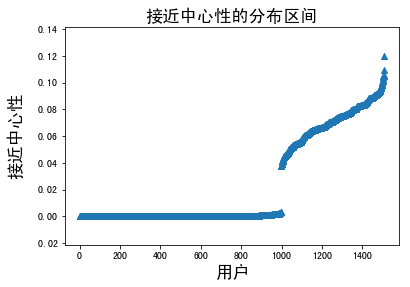

In [12]:
#可视化closeness_centrality的分布情况,考虑所有节点
closeness_centrality = nx.closeness_centrality(G1)
label_x = sorted(closeness_centrality)
label_y = []
for key in label_x:
    label_y.append(closeness_centrality[key])
plt.scatter(label_x,sorted(label_y), marker='^')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("用户",fontsize='xx-large')
plt.ylabel("接近中心性",fontsize='xx-large')
plt.title("接近中心性的分布区间",fontsize='xx-large')
plt.show()

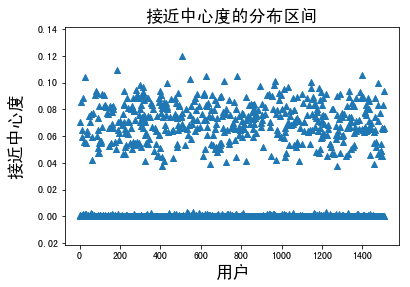

In [13]:
#可视化closeness_centrality的分布情况,考虑所有节点
closeness_centrality = nx.closeness_centrality(G1)
plt.scatter(closeness_centrality.keys(),closeness_centrality.values(), marker='^')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("用户",fontsize='xx-large')
plt.ylabel("接近中心度",fontsize='xx-large')
plt.title("接近中心度的分布区间",fontsize='xx-large')
plt.show()

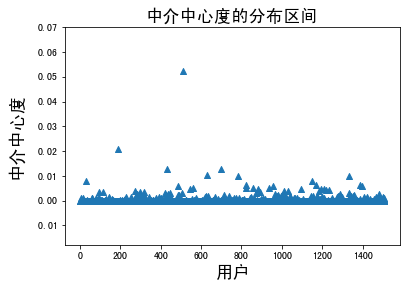

In [14]:
#可视化closeness_centrality的分布情况,考虑所有节点
betweenness_centrality = nx.betweenness_centrality(G1)
plt.scatter(betweenness_centrality.keys(),betweenness_centrality.values(), marker='^')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("用户",fontsize='xx-large')
plt.ylabel("中介中心度",fontsize='xx-large')
plt.title("中介中心度的分布区间",fontsize='xx-large')
plt.show()

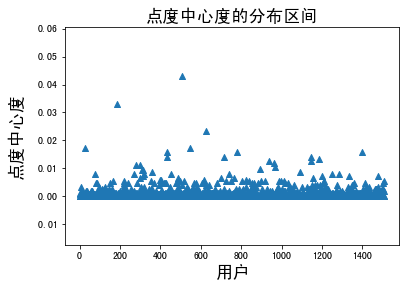

In [15]:
#可视化closeness_centrality的分布情况,考虑所有节点
degree_centrality = nx.degree_centrality(G1)
plt.scatter(degree_centrality.keys(),degree_centrality.values(), marker='^')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("用户",fontsize='xx-large')
plt.ylabel("点度中心度",fontsize='xx-large')
plt.title("点度中心度的分布区间",fontsize='xx-large')
plt.show()

In [ ]:
###生成攻击文件

In [16]:
df_matrix = np.zeros((n_users,n_items)) #评分矩阵
#得到用户-电影矩阵，内容为评分
for line in rating.itertuples():
    df_matrix[line[1],line[2]] = line[3]

In [17]:
def trust_attack_file(origin_trust_file, attack_type, attack_size, filler_size):
    temp_trust = pd.DataFrame.copy(trust,deep=True)#深拷贝
    n_profiles = round(attack_size*n_users)#伪造的用户数=攻击规模(例如5%)*用户数
    for i in range(n_profiles):
        value = random.gauss(mean,std)
        while value < 0:
            value = random.gauss(mean,std)
        num_links = round(value)
        target_links = random.sample(all_users,int(num_links))
        for user in target_links:
            temp_trust.loc[temp_trust.index.max() + 1] = [n_users + i + 1, user + 1, 1]
    temp_trust = temp_trust[temp_trust['trustor']<=n_users+n_profiles]#由于rating数据集只有1-1508的打分数据，所以需要筛选一下
    temp_trust = temp_trust[temp_trust['trustee']<=n_users+n_profiles]
    directory = "C://Users//user//Desktop//Bachelor Project//dataset//filmtrust//attack//"+  str(attack_type) +"//"+ str(attack_size) +"//" + "trust_attack.txt"
    temp_trust.to_csv(directory,sep=' ',index=False,header=False)
    print("生成社交关系攻击文件，攻击规模：",attack_size,"，攻击方式：",attack_type,"attack","，伪造用户数：",n_profiles)

In [18]:
selected_list = []
target_list = []
random_attack_mean = rating['rating'].mean()#在random attack中filler items的评分是整个数据库的平均分
all_users = list(rating['user_id'].unique())

In [19]:
filler_size = 0.15
for attack_size in [0.03,0.06,0.09,0.12,0.15]:
    for attack_type in ['average','random','bandwagon']:
        trust_attack_file(trust, attack_type, attack_size, filler_size)

生成社交关系攻击文件，攻击规模： 0.03 ，攻击方式： average attack ，伪造用户数： 45
生成社交关系攻击文件，攻击规模： 0.03 ，攻击方式： random attack ，伪造用户数： 45
生成社交关系攻击文件，攻击规模： 0.03 ，攻击方式： bandwagon attack ，伪造用户数： 45
生成社交关系攻击文件，攻击规模： 0.06 ，攻击方式： average attack ，伪造用户数： 90
生成社交关系攻击文件，攻击规模： 0.06 ，攻击方式： random attack ，伪造用户数： 90
生成社交关系攻击文件，攻击规模： 0.06 ，攻击方式： bandwagon attack ，伪造用户数： 90
生成社交关系攻击文件，攻击规模： 0.09 ，攻击方式： average attack ，伪造用户数： 136
生成社交关系攻击文件，攻击规模： 0.09 ，攻击方式： random attack ，伪造用户数： 136
生成社交关系攻击文件，攻击规模： 0.09 ，攻击方式： bandwagon attack ，伪造用户数： 136
生成社交关系攻击文件，攻击规模： 0.12 ，攻击方式： average attack ，伪造用户数： 181
生成社交关系攻击文件，攻击规模： 0.12 ，攻击方式： random attack ，伪造用户数： 181
生成社交关系攻击文件，攻击规模： 0.12 ，攻击方式： bandwagon attack ，伪造用户数： 181
生成社交关系攻击文件，攻击规模： 0.15 ，攻击方式： average attack ，伪造用户数： 226
生成社交关系攻击文件，攻击规模： 0.15 ，攻击方式： random attack ，伪造用户数： 226
生成社交关系攻击文件，攻击规模： 0.15 ，攻击方式： bandwagon attack ，伪造用户数： 226


In [20]:
def update(attack_matrix):
    global rating_map
    global random_attack_mean
    attack_df = pd.DataFrame(attack_matrix,index=None) 
    #将矩阵变成 用户-物品-评分 (将列的部分拆开)
                #0 0 5.0
                #0 1 3.0
    attack_df = attack_df.stack().reset_index()
    column_names = ['user_id','item_id','rating']
    attack_df.set_axis(axis=1,labels=column_names)
    attack_df = attack_df[attack_df['rating']>0] #？？？
    random_attack_mean = attack_df['rating'].mean()    
    ratings = pd.DataFrame(attack_df.groupby('item_id')['rating'].mean())
    ratings['num_of_ratings'] = pd.DataFrame(attack_df.groupby('item_id')['rating'].count())
    ratings.reset_index(inplace=True)
    rating_map = pd.DataFrame(ratings[['item_id','rating']])
    rating_map.set_index('item_id',inplace=True)  

In [21]:
#filler items随机选择，打分为整个数据库的平均值
#random_attack_matrix = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20)
def random_attack(percentage_profiles,fs,attack_purpose,isBandwagon,rating_matrix,x,y):
    global target_list
    global random_attack_mean
    #筛选出评分数小于x的前y个物品(降序)
    target_items = item_rating[item_rating['num_of_ratings']<x].sort_values('num_of_ratings',ascending = False).head(y)
    target_list = pd.Series.tolist(target_items['item_id'])#得到一个存储攻击目标的列表
    temp_matrix = np.matrix.copy(rating_matrix)  #对df.matrix(存储了所有用户-物品评分)拷贝
    n_users = temp_matrix.shape[0]#用户数
    n_profiles = round(percentage_profiles*n_users)#伪造的用户数=攻击规模(例如5%)*用户数
    temp_matrix.resize((n_users+n_profiles,n_items))#扩充profile部分，评分都是填0
    mean_rating = random_attack_mean#在一开始
    fs_size = round(fs*n_items)
    
    #给filler items部分补上分数，注意如果是target items则跳过
    for i in range(n_users,n_users+n_profiles):
        for j in range(fs_size):#每个profile填充fs_size个
            filler_index = random.randint(0,1681)
            if filler_index in target_list:
                j = j-1
            elif (isBandwagon ==1) and filler_index in selected_list:
                j = j-1
            else:
                temp_matrix[i,filler_index]=round(mean_rating)

    #给target items部分补上分数
    for i in range(n_users,n_users+n_profiles):
        for j in range(len(target_list)):
            if attack_purpose=='push':
                temp_matrix[i,target_list[j]]=5
            else:
                temp_matrix[i,target_list[j]]=1
    update(temp_matrix)
    return temp_matrix  

In [22]:
#filler items随机选择，打分为当前物品的平均值
def average_attack(percentage_profiles,fs,attack_purpose,isBandwagon,rating_matrix,x,y):
    global target_list
    target_items = item_rating[item_rating['num_of_ratings']<x].sort_values('num_of_ratings',ascending = False).head(y)
    target_list = pd.Series.tolist(target_items['item_id'])
    temp_matrix = np.matrix.copy(rating_matrix)
    n_users = temp_matrix.shape[0]
    n_profiles = round(percentage_profiles*n_users)
    temp_matrix.resize((n_users+n_profiles,n_items))
    fs_size = round(fs*n_items)
    for i in range(n_users,n_users+n_profiles):
        for j in range(fs_size):
            filler_index = random.randint(0,1681)
            if filler_index in target_list:
                j = j-1
            elif (isBandwagon ==1) and filler_index in selected_list:
                j = j-1
            else:
                temp_matrix[i,filler_index]=  round(pd.Series.tolist(rating_map.loc[(filler_index)])[0]) 
                
    for i in range(n_users,n_users+n_profiles):
        for j in range(len(target_list)):
            if attack_purpose=='push':
                temp_matrix[i,target_list[j]]=5
            else:
                temp_matrix[i,target_list[j]]=1
    update(temp_matrix)
    return temp_matrix 

In [23]:
#filler items采用random attack或者average attack均可，selected items有一个额外的列表来自热门、评分高的商品
def bandwagon_attack(percentage_profiles,fs,attack_purpose,bandwagon_attack_type,rating_matrix,x,y):
    global selected_list
    selected_items_size = pd.Series.tolist(round((0.05*item_rating.count())))
    selected_items = item_rating.sort_values('num_of_ratings',ascending=False).head(int(selected_items_size[0]*3))
    selected_items = selected_items.sort_values('rating',ascending=False).head(int(selected_items_size[0]))
    selected_list = pd.Series.tolist(selected_items['item_id'])
    if bandwagon_attack_type == 'Average':
        bandwagon_attack_matrix = average_attack(percentage_profiles,fs,attack_purpose,1,rating_matrix,x,y)
    else:
        bandwagon_attack_matrix = random_attack(percentage_profiles,fs,attack_purpose,1,rating_matrix,x,y)    
    for i in range(n_users,bandwagon_attack_matrix.shape[0]):
        for j in selected_list:
            bandwagon_attack_matrix[i,j] = 5
    update(bandwagon_attack_matrix)
    return bandwagon_attack_matrix   

In [24]:
#得到 item_id - rating 的键值对rating_map
rating_map = pd.DataFrame(item_rating[['item_id','rating']])
rating_map.set_index('item_id',inplace=True)

In [25]:
def rating_attack_file(origin_rating_file, attack_type, attack_size, filler_size):
    directory = "C://Users//user//Desktop//Bachelor Project//dataset//filmtrust//attack//"+  str(attack_type) +"//"+ str(attack_size) +"//" + "rating_attack.txt"
    #print(attack_type)
    
    if attack_type == 'random':
        temp_matrix = random_attack(attack_size,filler_size,'push',0,origin_rating_file,150,20) 
        attack_df = pd.DataFrame(temp_matrix,index=None) 
        attack_df = attack_df.stack().reset_index()
        column_names = ['user_id','item_id','rating']
        attack_df.set_axis(axis=1,labels=column_names)
        attack_df = attack_df[attack_df['rating']>0.01]
        #print(target_list)
    
    if attack_type == 'average':
        temp_matrix = average_attack(attack_size,filler_size,'push',0,origin_rating_file,150,20) 
        attack_df = pd.DataFrame(temp_matrix,index=None) 
        attack_df = attack_df.stack().reset_index()
        column_names = ['user_id','item_id','rating']
        attack_df.set_axis(axis=1,labels=column_names)
        attack_df = attack_df[attack_df['rating']>0.01]
        #print(target_list)
    
    if attack_type == 'bandwagon':
        temp_matrix = bandwagon_attack(attack_size,filler_size,'push','Random',origin_rating_file,150,20) 
        attack_df = pd.DataFrame(temp_matrix,index=None) 
        attack_df = attack_df.stack().reset_index()
        column_names = ['user_id','item_id','rating']
        attack_df.set_axis(axis=1,labels=column_names)
        attack_df = attack_df[attack_df['rating']>0.01]
        #print(target_list)
        
    attack_df.to_csv(directory,sep=' ',index=False,header=False)
    print("生成评分关系攻击文件，攻击规模：",attack_size,"，攻击方式：",attack_type,"attack")
    print(target_list)


In [26]:
filler_size = 0.15
for attack_size in [0.03,0.06,0.09,0.12,0.15]:
    for attack_type in ['random','average','bandwagon']:
        rating_attack_file(df_matrix, attack_type, attack_size, filler_size)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  # Remove the CWD from sys.path while we load stuff.


生成评分关系攻击文件，攻击规模： 0.03 ，攻击方式： random attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.


生成评分关系攻击文件，攻击规模： 0.03 ，攻击方式： average attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.


生成评分关系攻击文件，攻击规模： 0.03 ，攻击方式： bandwagon attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.06 ，攻击方式： random attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.06 ，攻击方式： average attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.06 ，攻击方式： bandwagon attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.09 ，攻击方式： random attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.09 ，攻击方式： average attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780, 335, 657]
生成评分关系攻击文件，攻击规模： 0.09 ，攻击方式： bandwagon attack
[217, 241, 317, 277, 674, 511, 804, 786, 346, 637, 431, 433, 58, 269, 588, 584, 340, 780

In [27]:
def prediction_shift(model, attack_type,attack_size):
    count = 0
    sum = 0
    directory = "C://Users//user//Desktop//Bachelor Project//dataset//filmtrust//Prediction Shift//"
    raw_dit = directory + model + "_raw.txt"
    #print(raw_dit)
    attack_dit = directory + model + "_" + attack_type + "_" + str(attack_size) + ".txt"
    #print(attack_dit)
    raw = pd.read_csv(raw_dit, names=['user', 'item', 'rating', 'pred_rating'], sep=' ')
    raw = raw[raw['item'].isin(target_list)]
    attack = pd.read_csv(attack_dit, names=['user', 'item', 'rating', 'pred_rating'], sep=' ')
    attack = attack[attack['item'].isin(target_list)]
    for line in raw.itertuples():
        user = line[1]
        item = line[2]
        temp = attack[(attack['user'] == user) & (attack['item'] == item)]
        if temp.size != 0:
            count += 1
            sum += temp.iloc[0][3] - line[4]
        else:
            continue
    return sum/count

In [28]:
SocialMF_random = []
SocialMF_average = []
SocialMF_bandwagon = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    SocialMF_random.append(prediction_shift('Social_MF', 'random', attack_size))
    SocialMF_average.append(prediction_shift('Social_MF', 'average', attack_size))
    SocialMF_bandwagon.append(prediction_shift('Social_MF', 'bandwagon', attack_size))

In [29]:
SoRec_random = []
SoRec_average = []
SoRec_bandwagon = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    SoRec_random.append(prediction_shift('SoRec', 'random', attack_size))
    SoRec_average.append(prediction_shift('SoRec', 'average', attack_size))
    SoRec_bandwagon.append(prediction_shift('SoRec', 'bandwagon', attack_size))

In [30]:
RSTE_random = []
RSTE_average = []
RSTE_bandwagon = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    RSTE_random.append(prediction_shift('RSTE', 'random', attack_size))
    RSTE_average.append(prediction_shift('RSTE', 'average', attack_size))
    RSTE_bandwagon.append(prediction_shift('RSTE', 'bandwagon', attack_size))

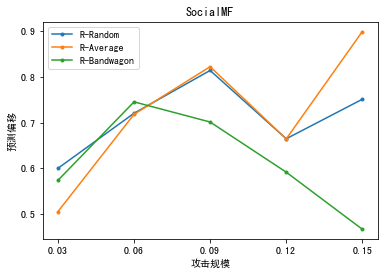

In [31]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(x,SocialMF_random,linestyle='-',label='R-Random',marker='.')
plt.plot(x,SocialMF_average,linestyle='-',label='R-Average',marker='.')
plt.plot(x,SocialMF_bandwagon,linestyle='-',label='R-Bandwagon',marker='.')
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("预测偏移")
plt.title("SocialMF")
plt.show()

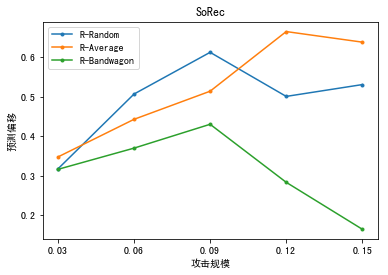

In [32]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(x,SoRec_random,linestyle='-',label='R-Random',marker='.')
plt.plot(x,SoRec_average,linestyle='-',label='R-Average',marker='.')
plt.plot(x,SoRec_bandwagon,linestyle='-',label='R-Bandwagon',marker='.')
plt.rcParams['axes.unicode_minus']=False
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("预测偏移")
plt.title("SoRec")
plt.show()

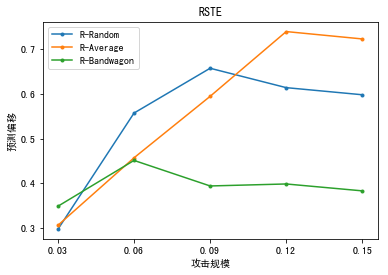

In [33]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(x,RSTE_random,linestyle='-',label='R-Random',marker='.')
plt.plot(x,RSTE_average,linestyle='-',label='R-Average',marker='.')
plt.plot(x,RSTE_bandwagon,linestyle='-',label='R-Bandwagon',marker='.')
plt.rcParams['axes.unicode_minus']=False
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("预测偏移")
plt.title("RSTE")
plt.show()

In [34]:
def hit_ratio(model, attack_type,attack_size, N):
    count = 0
    directory = "C://Users//user//Desktop//Bachelor Project//dataset//filmtrust//Prediction Shift//"
    if attack_size == 0:
        raw_dit = directory + model + "_raw.txt"
        attack_dit = raw_dit
    else:
        attack_dit = directory + model + "_" + attack_type + "_" + str(attack_size) + ".txt"
    df = pd.read_csv(attack_dit, names=['user', 'item', 'rating', 'pred_rating'], sep=' ')
    user_list = list(df['user'].unique())
    U = len(user_list)
    for user in user_list:
        top_df = df[df['user']==user].sort_values(by='pred_rating',ascending=False).head(10)
        topN = list(top_df['item'])
        if len(list(set(target_list).intersection(set(topN))))!=0:
            count +=1
            #print("item",list(set(target_list).intersection(set(topN))),"is recommended to user",user)
    return count/(N*U)


In [35]:
SocialMF_random_hit = []
SocialMF_average_hit = []
SocialMF_bandwagon_hit = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    SocialMF_random_hit.append(hit_ratio('Social_MF', 'random', attack_size,5))
    SocialMF_average_hit.append(hit_ratio('Social_MF', 'average', attack_size,5))
    SocialMF_bandwagon_hit.append(hit_ratio('Social_MF', 'bandwagon', attack_size,5))

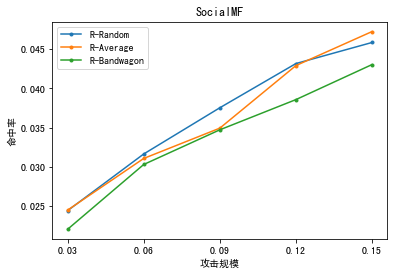

In [36]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.plot(x,SocialMF_random_hit,linestyle='-',label='R-Random',marker='.')
plt.plot(x,SocialMF_average_hit,linestyle='-',label='R-Average',marker='.')
plt.plot(x,SocialMF_bandwagon_hit,linestyle='-',label='R-Bandwagon',marker='.')
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("命中率")
plt.title("SocialMF")
plt.show()

In [37]:
SoRec_random_hit = []
SoRec_average_hit = []
SoRec_bandwagon_hit = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    SoRec_random_hit.append(hit_ratio('SoRec', 'random', attack_size,5))
    SoRec_average_hit.append(hit_ratio('SoRec', 'average', attack_size,5))
    SoRec_bandwagon_hit.append(hit_ratio('SoRec', 'bandwagon', attack_size,5))

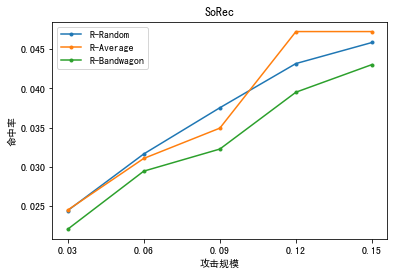

In [38]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.plot(x,SoRec_random_hit,linestyle='-',label='R-Random',marker='.')
plt.plot(x,SoRec_average_hit,linestyle='-',label='R-Average',marker='.')
plt.plot(x,SoRec_bandwagon_hit,linestyle='-',label='R-Bandwagon',marker='.')
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("命中率")
plt.title("SoRec")
plt.show()

In [39]:
RSTE_random_hit = []
RSTE_average_hit = []
RSTE_bandwagon_hit = []

for attack_size in [0.03, 0.06, 0.09, 0.12, 0.15]:
    RSTE_random_hit.append(hit_ratio('RSTE', 'random', attack_size,5))
    RSTE_average_hit.append(hit_ratio('RSTE', 'average', attack_size,5))
    RSTE_bandwagon_hit.append(hit_ratio('RSTE', 'bandwagon', attack_size,5))

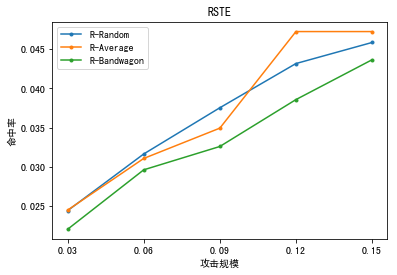

In [40]:
x = [0.03, 0.06, 0.09, 0.12, 0.15]
plt.plot(x,RSTE_random_hit,linestyle='-',label='R-Random',marker='.')
plt.plot(x,RSTE_average_hit,linestyle='-',label='R-Average',marker='.')
plt.plot(x,RSTE_bandwagon_hit,linestyle='-',label='R-Bandwagon',marker='.')
plt.legend()
plt.xticks(x)
plt.xlabel("攻击规模")
plt.ylabel("命中率")
plt.title("RSTE")
plt.show()

In [41]:
attack_size = 0.05
fs_size = 0.15
random_attack_matrix = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20) #得到加了伪造Profile的用户-物品评分矩阵
average_attack_matrix = average_attack(attack_size,fs_size,'push',0,df_matrix,150,20)
bandwagon_attack_matrix = bandwagon_attack(attack_size,fs_size,'push','Random',df_matrix,150,20)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  # Remove the CWD from sys.path while we load stuff.


In [42]:
def detection(attack_matrix,profile_threshold):
    df_temp = np.matrix.copy(attack_matrix)
    temp = pd.DataFrame(df_temp.T)#带shilling的用户-物品评分矩阵
    #转置并转换成DataFrame
    temp.replace(to_replace=0.0,value=np.nan,inplace=True)
    corr_df = temp.corr() #求出相关系数矩阵
    shilling_list=[]
    for line in corr_df.itertuples():#相关矩阵中的每个用户
        count = 0
        for i in range(1,attack_matrix.shape[0]):#每个用户的相关值
            if line[i] >= 0.95: #当前用户-物品的相关系数>0.95（相关阈值）
                count+=1
        if count >= profile_threshold*df_matrix.shape[0]: 
            #超过相关阈值的评分数>用户数*shilling profile比例
            shilling_list.append(line[0])#判定当前用户为shilling用户并加入列表
    return shilling_list

#temp_random_attack = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20)
#temp_shilling_list = detection(temp_random_attack,0.15)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'随机攻击下攻击规模对F-Score的影响')

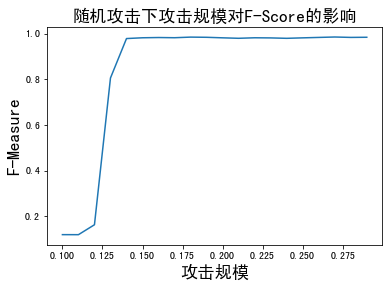

In [43]:
attack_size = 0.1
attack_sizes = []
f_scores = []
def f_measure():
    global attack_size
    for i in range(20):
        x = 0.15 #profile threshold
        temp_random_attack = random_attack(attack_size,fs_size,'push',0,df_matrix,150,20)#生成
        temp_shilling_list = detection(temp_random_attack,x)
        while(True):
            x-=0.01
            temp_shilling_list = detection(temp_random_attack,x)
            if (not(len(temp_shilling_list)==0)):#如果检测出shilling profile则跳出循环
                break
        count = 0
        for i in temp_shilling_list:
            if i>=944:
                count+=1
        if(not(count==0)):
            precision = count/len(temp_shilling_list)
            recall = count/round(attack_size * df_matrix.shape[0])
            f_score = 2*precision*recall/(precision+recall)
            f_scores.append(f_score)
            attack_sizes.append(attack_size)
        else:
            f_scores.append(0)
            attack_sizes.append(attack_size)
        attack_size+=0.01

f_measure()
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
analysis = pd.DataFrame(attack_sizes,columns=["攻击规模"])
analysis["F_Score"] = f_scores
plt.plot(attack_sizes,f_scores)
plt.xlabel("攻击规模",fontsize='xx-large')
plt.ylabel("F-Measure",fontsize='xx-large')
plt.title("随机攻击下攻击规模对F-Score的影响",fontsize='xx-large')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'均值攻击下攻击规模对F-Score的影响')

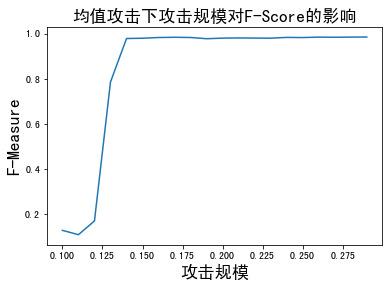

In [44]:
attack_size = 0.1
attack_sizes = []
f_scores = []
def f_measure():
    global attack_size
    for i in range(20):
        x = 0.15 #profile threshold
        temp_average_attack = average_attack(attack_size,fs_size,'push',0,df_matrix,150,20)#生成
        temp_shilling_list = detection(temp_average_attack,x)
        while(True):
            x-=0.01
            temp_shilling_list = detection(temp_average_attack,x)
            if (not(len(temp_shilling_list)==0)):#如果检测出shilling profile则跳出循环
                break
        count = 0
        for i in temp_shilling_list:
            if i>=944:
                count+=1
        if(not(count==0)):
            precision = count/len(temp_shilling_list)
            recall = count/round(attack_size * df_matrix.shape[0])
            f_score = 2*precision*recall/(precision+recall)
            f_scores.append(f_score)
            attack_sizes.append(attack_size)
        else:
            f_scores.append(0)
            attack_sizes.append(attack_size)
        attack_size+=0.01

f_measure()
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
analysis = pd.DataFrame(attack_sizes,columns=["攻击规模"])
analysis["F_Score"] = f_scores
plt.plot(attack_sizes,f_scores)
plt.xlabel("攻击规模",fontsize='xx-large')
plt.ylabel("F-Measure",fontsize='xx-large')
plt.title("均值攻击下攻击规模对F-Score的影响",fontsize='xx-large')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'流行攻击下攻击规模对F-Score的影响')

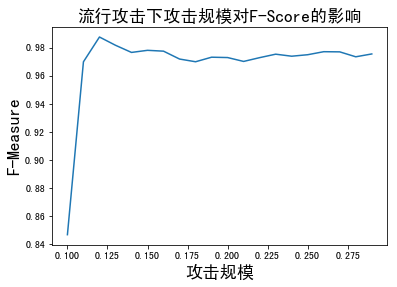

In [45]:
attack_size = 0.1
attack_sizes = []
f_scores = []
def f_measure():
    global attack_size
    for i in range(20):
        x = 0.15 #profile threshold
        temp_bandwagon_attack = bandwagon_attack(attack_size,fs_size,'push',0,df_matrix,150,20)#生成
        temp_shilling_list = detection(temp_bandwagon_attack,x)
        while(True):
            x-=0.01
            temp_shilling_list = detection(temp_bandwagon_attack,x)
            if (not(len(temp_shilling_list)==0)):#如果检测出shilling profile则跳出循环
                break
        count = 0
        for i in temp_shilling_list:
            if i>=944:
                count+=1
        if(not(count==0)):
            precision = count/len(temp_shilling_list)
            recall = count/round(attack_size * df_matrix.shape[0])
            f_score = 2*precision*recall/(precision+recall)
            f_scores.append(f_score)
            attack_sizes.append(attack_size)
        else:
            f_scores.append(0)
            attack_sizes.append(attack_size)
        attack_size+=0.01

f_measure()
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
analysis = pd.DataFrame(attack_sizes,columns=["攻击规模"])
analysis["F_Score"] = f_scores
plt.plot(attack_sizes,f_scores)
plt.xlabel("攻击规模",fontsize='xx-large')
plt.ylabel("F-Measure",fontsize='xx-large')
plt.title("流行攻击下攻击规模对F-Score的影响",fontsize='xx-large')